In [1]:
%matplotlib inline
import logging
import datetime
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
 

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv3D, MaxPooling3D
from keras import backend as K
from keras.layers.core import Activation, Dense, Dropout, Flatten
from keras.layers.advanced_activations import ReLU
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import SGD
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model


Using TensorFlow backend.


In [2]:
#Tuning
dataset = "ModelNet10"  #or "ModelNet40"
batch_size = 128
epochs = 200
learning_rate = 0.01

In [3]:
if dataset == "ModelNet10":
    data_dir = "data10/"
    weights_dir = "weights10/"
    num_classes = 10
    class_name_modelnet = [
    'bathtub',
    'chair',
    'dresser',
    'night_stand',
    'table',
    'bed',
    'desk',
    'monitor',
    'sofa',
    'toilet',
    ]

In [4]:
if dataset == "ModelNet40":
    data_dir = "data40/"
    weights_dir = "weights40/"
    num_classes = 40
    class_name_modelnet = [
    'airplane',
    'bookshelf',
    'chair',
    'desk',
    'glass_box',
    'laptop',
    'person',
    'range_hood',
    'stool',
    'tv_stand',
    'bathtub',
    'bottle',
    'cone',
    'door',
    'guitar',
    'mantel',
    'piano',
    'sink',
    'table',
    'vase',
    'bed',
    'bowl',
    'cup',
    'dresser',
    'keyboard',
    'monitor',
    'plant',
    'sofa',
    'tent',
    'wardrobe',
    'bench',
    'car',
    'curtain',
    'flower_pot',
    'lamp',
    'night_stand',
    'radio',
    'stairs',
    'toilet',
    'xbox',
    ]

In [5]:
train_or_test = ["train","test"]

In [6]:
if os.path.exists(weights_dir) == False:
    os.mkdir(weights_dir)

In [7]:
#set logging level DEBUG and output to stdout
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

In [8]:
# optimizer = SGD(lr=0.01, momentum=0.9, decay=0.00016667, nesterov=False)
optimizer = SGD(lr=learning_rate, momentum=0.9, decay=0.00016667, nesterov=False)

# init model
model = Sequential()

# convolution 1
model.add(Conv3D(input_shape=(1, 32, 32, 32),
                            nb_filter=32,
                            kernel_dim1=5,
                            kernel_dim2=5,
                            kernel_dim3=5,
                            init='normal',
                            border_mode='valid',
                            subsample=(2, 2, 2),
                            dim_ordering='th',
                            W_regularizer=l2(0.001),
                            b_regularizer=l2(0.001),
                            ))

#Activation Leaky ReLu
model.add(Activation(ReLU()))

# dropout 1
model.add(Dropout(p=0.3))

# convolution 2
model.add(Conv3D(nb_filter=32,
                            kernel_dim1=3,
                            kernel_dim2=3,
                            kernel_dim3=3,
                            init='normal',
                            border_mode='valid',
                            subsample=(1, 1, 1),
                            dim_ordering='th',
                            W_regularizer=l2(0.001),
                            b_regularizer=l2(0.001),
                            ))

#Activation Leaky ReLu
model.add(Activation(ReLU()))

# max pool 1
model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           strides=None,
                           border_mode='valid',
                           dim_ordering='th'))

# dropout 2
model.add(Dropout(p=0.4))

# dense 1 (fully connected layer)
model.add(Flatten())

model.add(Dense(output_dim=128,
                    init='normal',
                    activation='linear',
                    W_regularizer=l2(0.001),
                    b_regularizer=l2(0.001),
                    ))

# dropout 3
model.add(Dropout(p=0.5))

# dense 2 (fully connected layer)
model.add(Dense(output_dim=num_classes,
                    init='normal',
                    activation='linear',
                    W_regularizer=l2(0.001),
                    b_regularizer=l2(0.001),
                    ))

#Activation Softmax
model.add(Activation("softmax"))

# compile model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])


/home/takitani/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(input_shape=(1, 32, 32..., kernel_size=(5, 5, 5), filters=32, strides=(2, 2, 2), padding="valid", data_format="channels_first", kernel_initializer="normal", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg...)`
/home/takitani/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/keras/activations.py:186: UserWarning: Do not pass a layer instance (such as ReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/home/takitani/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.3)`
/home/takitani/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launc

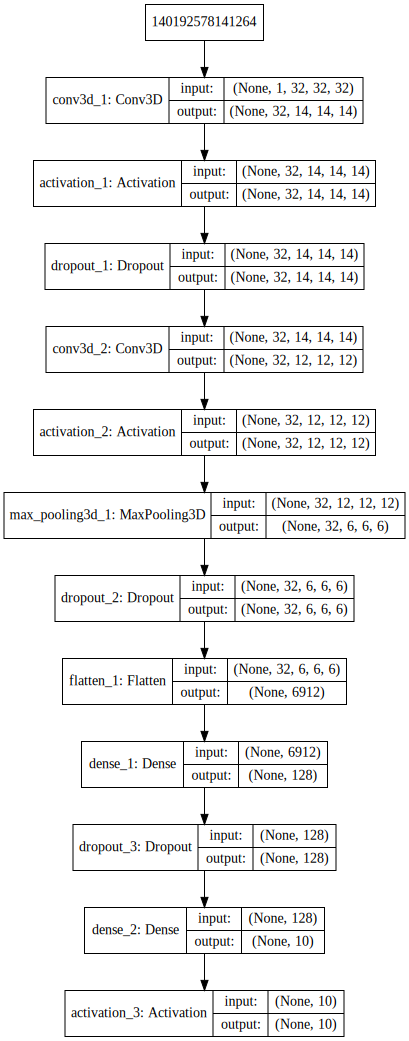

In [9]:
#可視化
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [10]:
#サマリーの表示
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 32, 14, 14, 14)    4032      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 14, 14, 14)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 14, 14, 14)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 32, 12, 12, 12)    27680     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 12, 12, 12)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 32, 6, 6, 6)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 6, 6, 6)       0         
__________

In [11]:
#モデルの図を保存
plot_model(model, to_file='model.png',show_shapes='True')

In [12]:
x_train = np.load("data10/x_train.npy")
x_test = np.load("data10/x_test.npy")
y_train = np.load("data10/y_train.npy")
y_test = np.load("data10/y_test.npy")

In [13]:
x_train.shape

(3991, 1, 32, 32, 32)

In [14]:
y_train.shape

(3991, 10)

In [15]:
x_test.shape

(908, 1, 32, 32, 32)

In [16]:
y_test.shape

(908, 10)

In [17]:
result = model.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_data=(x_test, y_test))

time_now = datetime.datetime.now()
time_now = "_{0}_{1}_{2}_{3}_{4}_{5}".format(time_now.year, time_now.month, time_now.day,
                                             time_now.hour, time_now.minute, time_now.second)
logging.info("save model weights as [weights_{0}.h5]".format(time_now))
model.save_weights("weights_{0}.h5".format(time_now), False)

Train on 3991 samples, validate on 908 samples
Epoch 1/200
3991/3991 [==============================] - 5s 1ms/step - loss: 3.7611 - acc: 0.5214 - val_loss: 3.0400 - val_acc: 0.7335
Epoch 2/200
3991/3991 [==============================] - 3s 862us/step - loss: 2.9429 - acc: 0.7710 - val_loss: 2.8486 - val_acc: 0.7941
Epoch 3/200
3991/3991 [==============================] - 3s 855us/step - loss: 2.7685 - acc: 0.8296 - val_loss: 2.7451 - val_acc: 0.8128
Epoch 4/200
3991/3991 [==============================] - 3s 807us/step - loss: 2.6712 - acc: 0.8509 - val_loss: 2.7172 - val_acc: 0.7974
Epoch 5/200
3991/3991 [==============================] - 3s 750us/step - loss: 2.5823 - acc: 0.8657 - val_loss: 2.6058 - val_acc: 0.8381
Epoch 6/200
3991/3991 [==============================] - 3s 783us/step - loss: 2.5136 - acc: 0.8847 - val_loss: 2.5723 - val_acc: 0.8469
Epoch 7/200
3991/3991 [==============================] - 3s 786us/step - loss: 2.4458 - acc: 0.8913 - val_loss: 2.5318 - val_acc: 0.8

KeyboardInterrupt: 

In [18]:
loss,acc = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

Test loss: 1.8994650678
Test accuracy: 0.867841409954


In [19]:

plt.plot(range(1, epochs+1), result.history['acc'], label="training")
plt.plot(range(1, epochs+1), result.history['val_acc'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend()
plt.title("lr = {}".format(learning_rate))
plt.show()


NameError: name 'result' is not defined